# 0413 ~ 0424 Team Assignment 01 :
### predict customer's gender of department store

In [1]:
%load_ext watermark
%watermark -v -p numpy,scipy,sklearn,pandas,matplotlib

CPython 3.7.6
IPython 7.12.0

numpy 1.18.1
scipy 1.4.1
sklearn 0.22.1
pandas 1.0.1
matplotlib 3.1.3


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures

from imblearn.under_sampling import *
from imblearn.combine import SMOTETomek

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

# Data Reading & Checking

In [5]:
train = pd.read_csv('../data/train.csv', encoding='cp949', index_col='custid')
train.head(2)

,gender,총구매액,구매건수,평균구매가격,평균할부개월수,구매브랜드종류,내점일수,수입상품_구매비율,주말방문비율,가을_구매건수,겨울_구매건수,봄_구매건수,여름_구매건수,아침_구매건수,저녁_구매건수,점심_구매건수,주구매코너
custid,,,,,,,,,,,,,,,,,
18,0,680100,15,45340,1.7,9,10,26.7,100.0,NaN,9.0,6.0,NaN,NaN,6.0,9.0,화.장품
21,0,353450,9,39272,1.2,6,8,11.1,37.5,NaN,5.0,4.0,NaN,3.0,NaN,6.0,영.캐주얼


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 18 to 49993
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   gender     5000 non-null   int64  
 1   총구매액       5000 non-null   int64  
 2   구매건수       5000 non-null   int64  
 3   평균구매가격     5000 non-null   int64  
 4   평균할부개월수    5000 non-null   float64
 5   구매브랜드종류    5000 non-null   int64  
 6   내점일수       5000 non-null   int64  
 7   수입상품_구매비율  5000 non-null   float64
 8   주말방문비율     5000 non-null   float64
 9   가을_구매건수    4055 non-null   float64
 10  겨울_구매건수    4103 non-null   float64
 11  봄_구매건수     4311 non-null   float64
 12  여름_구매건수    3978 non-null   float64
 13  아침_구매건수    3558 non-null   float64
 14  저녁_구매건수    4033 non-null   float64
 15  점심_구매건수    4855 non-null   float64
 16  주구매코너      5000 non-null   object 
dtypes: float64(10), int64(6), object(1)
memory usage: 703.1+ KB


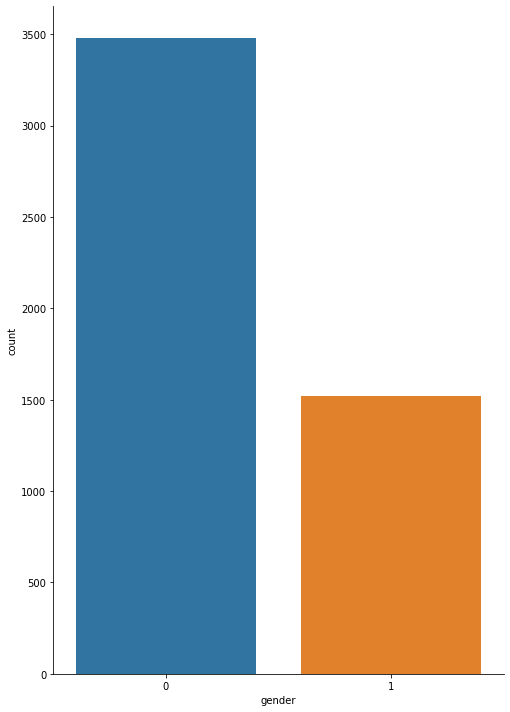

In [7]:
# 그래프를 통해 직관적으로 봤을때도 여성비율이 남성보다
# 최소 두배이상은 차이나 나보임
sns.catplot(x="gender", hue=None, col=None,
                data=train, kind="count",
                height=10, aspect=.7)

In [8]:
# 여성이 남성의 2.287310979618672 배이다.
# 3479 / 1521 = 2.287310979618672
# 1521 * 2.287310979618672 = 3479.0000000000005
train['gender'].value_counts()

0    3479
1    1521
Name: gender, dtype: int64

In [9]:
# 남녀간 아침구매 빈도
gender_purcnt = train.groupby(['gender', '아침_구매건수'])['구매건수'].agg('count').to_frame()
df_purcnt = gender_purcnt.reset_index()
df_purcnt.columns = ['gender', 'morning purchase', 'counts']

- <font color = "#CC3D3D">학습데이터에 주구매코너는 사용하기 않을 예정이기 때문에 주구매코너를 제외한 나머지 경우들 중 아침구매건수에서 그나마 차이남<font>

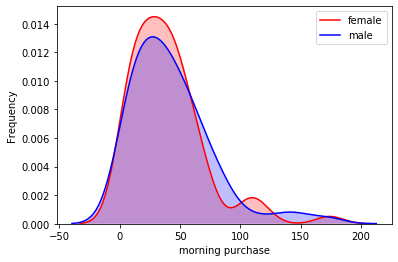

In [10]:
# 남녀간에 아침에 구매하는 빈도가 약간 차이가 있음
g = sns.kdeplot(df_purcnt["morning purchase"][(df_purcnt["gender"] == 0) &\
                                               (df_purcnt["morning purchase"].notnull())], color="Red", shade = True)
g = sns.kdeplot(df_purcnt["morning purchase"][(df_purcnt["gender"] == 1) &\
                                               (df_purcnt["morning purchase"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("morning purchase")
g.set_ylabel("Frequency")
g = g.legend(["female","male"])

In [11]:
data_check = train.copy()
data_check['morning_shop'] = data_check['아침_구매건수'] >= 1
data_check[['morning_shop']].head()

,morning_shop
custid,
18,False
21,True
23,True
26,False
35,False


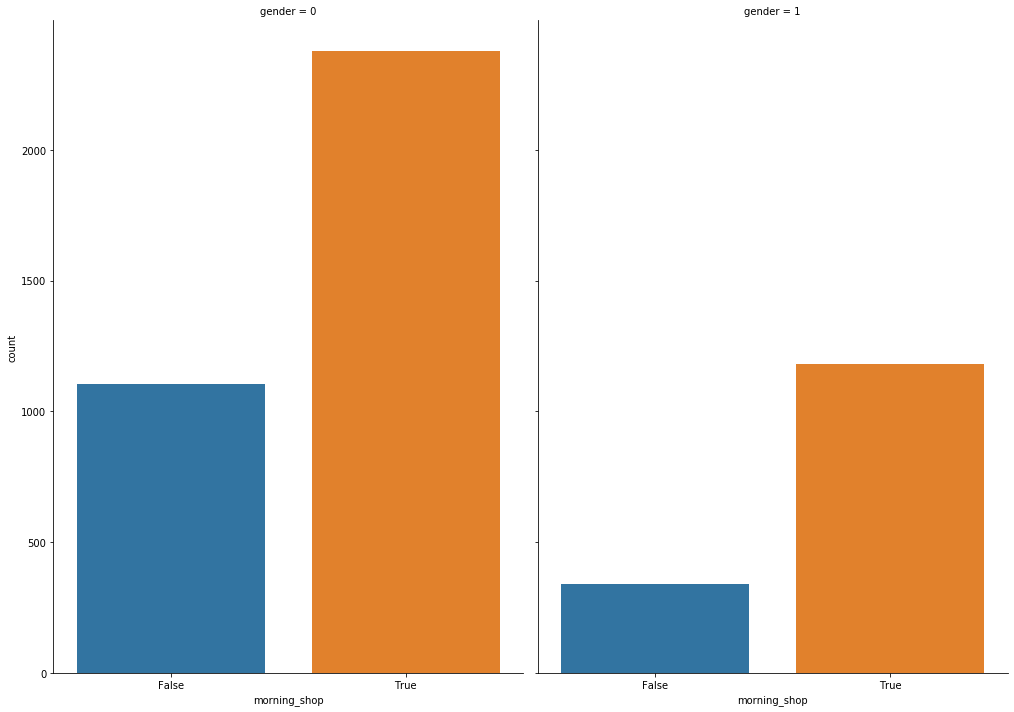

In [12]:
# 남녀간 아침구매 빈도 차이
sns.catplot(x="morning_shop", hue=None, col="gender",
                data=data_check, kind="count",
                height=10, aspect=.7)

In [13]:
pd.pivot_table(data_check, index="gender", values="morning_shop")

,morning_shop
gender,
0,0.682955
1,0.777120


# Fill Missing Values

<font color = "#CC3D3D">데이터의 계절,시간대 별로 구매한 건수가 NoN인 곳들은 그 상황에서 구매하지 않았다.<font>

<font color = "#CC3D3D">즉, 0건이기 때문에 이를 먼저 채워줌 그리고 한글 데이터인 주구매코너는 모델링을 위해<font>

<font color = "#CC3D3D">정수형으로 바꿔준 후 제거 예정<font>

In [14]:
train.isnull().sum()

gender          0
총구매액            0
구매건수            0
평균구매가격          0
평균할부개월수         0
구매브랜드종류         0
내점일수            0
수입상품_구매비율       0
주말방문비율          0
가을_구매건수       945
겨울_구매건수       897
봄_구매건수        689
여름_구매건수      1022
아침_구매건수      1442
저녁_구매건수       967
점심_구매건수       145
주구매코너           0
dtype: int64

In [15]:
# 구매 건수가 0건임을 표현하기 위해 fillna를
# 사용하여 일괄적으로 값을 0으로 바꿔줍니다.
train.fillna(value=0, inplace=True)

# 0이라는 값이 채워졌는지 확인 합니다.
train.isnull().sum().sum()

0

In [16]:
import category_encoders as ce
cat_features = ['주구매코너']
count_enc = ce.CountEncoder()
count_encoded = count_enc.fit_transform(train[cat_features])
count_encoded.head()

,주구매코너
custid,
18,1206
21,246
23,68
26,1206
35,75


In [ ]:
train

In [14]:
obj = ['주구매코너']
train[obj] = train[obj].apply(lambda x: x.astype('category').cat.codes)
train.head(1)

,gender,총구매액,구매건수,평균구매가격,평균할부개월수,구매브랜드종류,내점일수,수입상품_구매비율,주말방문비율,가을_구매건수,겨울_구매건수,봄_구매건수,여름_구매건수,아침_구매건수,저녁_구매건수,점심_구매건수,주구매코너
custid,,,,,,,,,,,,,,,,,
18,0,680100,15,45340,1.7,9,10,26.7,100.0,0.0,9.0,6.0,0.0,0.0,6.0,9.0,24


# Modeling

In [15]:
# 나누기 이전 데이터의 비율과 많이 차이 안나게 하도록 난수초깃값을 42로
# 지정하여 나눠준 후 확인합니다.
y = train['gender']
x = train.drop('gender', axis=1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape)

(3750, 16) (1250, 16)


In [16]:
print(train['gender'].value_counts() / len(train))
print(y_train.value_counts() / len(y_train))

0    0.6958
1    0.3042
Name: gender, dtype: float64
0    0.693067
1    0.306933
Name: gender, dtype: float64


<font color = "#CC3D3D">총 9개의 알고리즘을 적용해봤습니다.<font>
- <font color = "#CC3D3D">neural network 개선 안됨<font>
- <font color = "#CC3D3D">linearSVC 개선 안됨<font>
- <font color = "#CC3D3D">logistic regression 개선 안됨<font>

In [17]:
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)

In [18]:
# decision tree 로 모델링
tree = DecisionTreeClassifier(max_depth=6, random_state=0); tree.fit(X_train, y_train)
pred_tree = tree.predict(X_test); print(classification_report(y_test, pred_tree))
print("-----------------------------------")
print("Dummy model:"); print(confusion_matrix(y_test, pred_dummy))
print("Decision tree:"); print(confusion_matrix(y_test, pred_tree))

              precision    recall  f1-score   support

           0       0.71      0.90      0.80       880
           1       0.37      0.13      0.19       370

    accuracy                           0.68      1250
   macro avg       0.54      0.52      0.50      1250
weighted avg       0.61      0.68      0.62      1250

-----------------------------------
Dummy model:
[[880   0]
 [370   0]]
Decision tree:
[[795  85]
 [321  49]]


In [19]:
# svm 으로 모델링
svm = SVC(random_state=0); svm.fit(X_train, y_train)
pred_svm = svm.predict(X_test); print(classification_report(y_test, pred_svm))
print("-----------------------------------")
print("Dummy model:")
print(confusion_matrix(y_test, pred_dummy))
print("Decision tree:")
print(confusion_matrix(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.70      1.00      0.83       880
           1       0.33      0.00      0.01       370

    accuracy                           0.70      1250
   macro avg       0.52      0.50      0.42      1250
weighted avg       0.59      0.70      0.58      1250

-----------------------------------
Dummy model:
[[880   0]
 [370   0]]
Decision tree:
[[878   2]
 [369   1]]


In [20]:
# gradientboosting 으로 모델링
gbm = GradientBoostingClassifier(n_estimators=200, random_state=0); gbm.fit(X_train, y_train)
pred_gbm = gbm.predict(X_test); print(classification_report(y_test, pred_gbm))
print("-----------------------------------")
print("Dummy model:"); print(confusion_matrix(y_test, pred_dummy))
print("Decision tree:"); print(confusion_matrix(y_test, pred_gbm))

              precision    recall  f1-score   support

           0       0.71      0.93      0.81       880
           1       0.42      0.12      0.18       370

    accuracy                           0.69      1250
   macro avg       0.57      0.52      0.50      1250
weighted avg       0.63      0.69      0.62      1250

-----------------------------------
Dummy model:
[[880   0]
 [370   0]]
Decision tree:
[[820  60]
 [327  43]]


In [21]:
# AdaBoost 로 모델링
ada = AdaBoostClassifier(n_estimators=200, random_state=0); ada.fit(X_train, y_train)
pred_ada = ada.predict(X_test); print(classification_report(y_test, pred_ada))
print("-----------------------------------")
print("Dummy model:"); print(confusion_matrix(y_test, pred_dummy))
print("Decision tree:"); print(confusion_matrix(y_test, pred_ada))

              precision    recall  f1-score   support

           0       0.71      0.93      0.81       880
           1       0.39      0.11      0.17       370

    accuracy                           0.68      1250
   macro avg       0.55      0.52      0.49      1250
weighted avg       0.62      0.68      0.62      1250

-----------------------------------
Dummy model:
[[880   0]
 [370   0]]
Decision tree:
[[815  65]
 [329  41]]


In [22]:
# randomforest 로 모델링
ranfor = RandomForestClassifier(max_depth=6, random_state=0); ranfor.fit(X_train, y_train)
pred_ranfor = ranfor.predict(X_test); print(classification_report(y_test, pred_ranfor))
print("-----------------------------------")
print("Dummy model:"); print(confusion_matrix(y_test, pred_dummy))
print("Decision tree:"); print(confusion_matrix(y_test, pred_ranfor))

              precision    recall  f1-score   support

           0       0.71      0.98      0.82       880
           1       0.50      0.04      0.07       370

    accuracy                           0.70      1250
   macro avg       0.60      0.51      0.45      1250
weighted avg       0.65      0.70      0.60      1250

-----------------------------------
Dummy model:
[[880   0]
 [370   0]]
Decision tree:
[[866  14]
 [356  14]]


In [23]:
#  KNeighbors 로 모델링
knn = KNeighborsClassifier(); knn.fit(X_train, y_train)
pred_knn = knn.predict(X_test); print(classification_report(y_test, pred_knn))
print("-----------------------------------")
print("Dummy model:"); print(confusion_matrix(y_test, pred_dummy))
print("Decision tree:"); print(confusion_matrix(y_test, pred_knn))

              precision    recall  f1-score   support

           0       0.71      0.82      0.76       880
           1       0.31      0.19      0.24       370

    accuracy                           0.64      1250
   macro avg       0.51      0.51      0.50      1250
weighted avg       0.59      0.64      0.61      1250

-----------------------------------
Dummy model:
[[880   0]
 [370   0]]
Decision tree:
[[725 155]
 [299  71]]


<font color = "#CC3D3D">SMOTE + Tomek<font>
- <font color = "#CC3D3D">적용한 모든 알고리즘이 개선됨<font>

In [24]:
XX, yy = SMOTETomek(random_state=0).fit_sample(X_train, y_train)
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(XX, yy)
y_pred = tree.predict(X_test)
print(classification_report(y_test, y_pred))
print("-----------------------------------")
print("Dummy model:"); print(confusion_matrix(y_test, pred_dummy))
print("Decision tree:"); print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.56      0.63       880
           1       0.33      0.53      0.41       370

    accuracy                           0.55      1250
   macro avg       0.54      0.54      0.52      1250
weighted avg       0.62      0.55      0.57      1250

-----------------------------------
Dummy model:
[[880   0]
 [370   0]]
Decision tree:
[[490 390]
 [175 195]]


In [25]:
XX, yy = SMOTETomek(random_state=0).fit_sample(X_train, y_train)
svm = SVC(random_state=0)
svm.fit(XX, yy)
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))
print("-----------------------------------")
print("Dummy model:"); print(confusion_matrix(y_test, pred_dummy))
print("Decision tree:"); print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.74      0.74       880
           1       0.37      0.36      0.37       370

    accuracy                           0.63      1250
   macro avg       0.55      0.55      0.55      1250
weighted avg       0.63      0.63      0.63      1250

-----------------------------------
Dummy model:
[[880   0]
 [370   0]]
Decision tree:
[[651 229]
 [235 135]]


In [26]:
XX, yy = SMOTETomek(random_state=0).fit_sample(X_train, y_train)
gbm = GradientBoostingClassifier(n_estimators=200, random_state=0)
gbm.fit(XX, yy)
y_pred = gbm.predict(X_test)
print(classification_report(y_test, y_pred))
print("-----------------------------------")
print("Dummy model:"); print(confusion_matrix(y_test, pred_dummy))
print("Decision tree:"); print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.82      0.78       880
           1       0.43      0.32      0.36       370

    accuracy                           0.67      1250
   macro avg       0.58      0.57      0.57      1250
weighted avg       0.65      0.67      0.66      1250

-----------------------------------
Dummy model:
[[880   0]
 [370   0]]
Decision tree:
[[723 157]
 [253 117]]


In [27]:
XX, yy = SMOTETomek(random_state=0).fit_sample(X_train, y_train)
ada = AdaBoostClassifier(n_estimators=200, random_state=0)
ada.fit(XX, yy)
y_pred = ada.predict(X_test)
print(classification_report(y_test, y_pred))
print("-----------------------------------")
print("Dummy model:"); print(confusion_matrix(y_test, pred_dummy))
print("Decision tree:"); print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.75      0.74       880
           1       0.38      0.36      0.37       370

    accuracy                           0.64      1250
   macro avg       0.56      0.56      0.56      1250
weighted avg       0.63      0.64      0.63      1250

-----------------------------------
Dummy model:
[[880   0]
 [370   0]]
Decision tree:
[[660 220]
 [235 135]]


In [28]:
XX, yy = SMOTETomek(random_state=0).fit_sample(X_train, y_train)
ranfor = RandomForestClassifier(max_depth=6, random_state=0)
ranfor.fit(XX, yy)
y_pred = ranfor.predict(X_test)
print(classification_report(y_test, y_pred))
print("-----------------------------------")
print("Dummy model:"); print(confusion_matrix(y_test, pred_dummy))
print("Decision tree:"); print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.66      0.70       880
           1       0.36      0.45      0.40       370

    accuracy                           0.60      1250
   macro avg       0.55      0.56      0.55      1250
weighted avg       0.63      0.60      0.61      1250

-----------------------------------
Dummy model:
[[880   0]
 [370   0]]
Decision tree:
[[582 298]
 [203 167]]


In [29]:
XX, yy = SMOTETomek(random_state=0).fit_sample(X_train, y_train)
knn = KNeighborsClassifier()
knn.fit(XX, yy)
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))
print("-----------------------------------")
print("Dummy model:"); print(confusion_matrix(y_test, pred_dummy))
print("Decision tree:"); print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.56      0.62       880
           1       0.29      0.42      0.34       370

    accuracy                           0.52      1250
   macro avg       0.49      0.49      0.48      1250
weighted avg       0.58      0.52      0.54      1250

-----------------------------------
Dummy model:
[[880   0]
 [370   0]]
Decision tree:
[[489 391]
 [213 157]]


# Feature Engineering

In [30]:
def create_feature(data):
    # 내점구매율에 대한 아침에 구매한 건수의 비율을 표현
    arithmetic = (data['구매건수']/data['내점일수']) / data['구매건수'] * data['아침_구매건수']
    apply = np.where(data['아침_구매건수']==0,0,arithmetic)
    local = data.columns.get_loc('내점일수') + 1
    data.insert(loc=local, column='morning visit purchase ratio', value=apply)

    # 아침에 구매한 가격을 평균구매가격으로 곱하여 아침에 구매한 총 건수에 대한 평균가격을 표현
    multiply = data['평균구매가격'] * data['아침_구매건수']
    apply = np.where(data['아침_구매건수']==0,0,multiply)
    local = data.columns.get_loc('아침_구매건수')
    data.insert(loc=local, column='morning purchase price', value=apply)

    # 구매건수 중 아침에 구매한 비율을 표현
    ratio = data['아침_구매건수'] / data['구매건수']
    apply = np.where(train['아침_구매건수']==0,0,ratio)
    local = data.columns.get_loc('아침_구매건수') + 1
    data.insert(loc=local, column='morning purchase ratio', value=apply)

    # 아침부터 점심까지 구매한 평균가격을 표현
    multiply = data['평균구매가격'] * (data['아침_구매건수'] + data['점심_구매건수'])
    apply = np.where((data['아침_구매건수']==0) & (data['점심_구매건수']==0),0,multiply)
    local = data.columns.get_loc('morning purchase ratio') + 1
    data.insert(loc=local, column='morning-lunch purchase price', value=apply)

    # 아침부터 점심까지 구매한 건수를 표현
    plus = data['아침_구매건수'] + data['점심_구매건수']
    apply = np.where((data['아침_구매건수']==0) & (data['점심_구매건수']==0),0,plus)
    local = data.columns.get_loc('morning-lunch purchase price') + 1
    data.insert(loc=local, column='morning-lunch purchase count', value=apply)

    # 아침부터 점심까지 구매한 비율을 표현
    plus = (data['아침_구매건수'] + data['점심_구매건수']) / data['구매건수']
    apply = np.where((data['아침_구매건수']==0) & (data['점심_구매건수']==0),0,plus)
    local = data.columns.get_loc('morning-lunch purchase count') + 1
    data.insert(loc=local, column='morning-lunch purchase ratio', value=apply)
    
    return

In [31]:
create_feature(train)
train.head(1).T

custid,18
gender,0.0
총구매액,680100.0
구매건수,15.0
평균구매가격,45340.0
평균할부개월수,1.7
구매브랜드종류,9.0
내점일수,10.0
morning visit purchase ratio,0.0
수입상품_구매비율,26.7
주말방문비율,100.0


In [32]:
corr = train.corr()
corr.gender.sort_values(ascending=False)

gender                          1.000000
morning visit purchase ratio    0.131328
morning-lunch purchase ratio    0.129500
아침_구매건수                         0.127779
morning purchase ratio          0.122799
morning purchase price          0.120622
morning-lunch purchase count    0.119054
morning-lunch purchase price    0.111192
여름_구매건수                         0.101900
총구매액                            0.099137
점심_구매건수                         0.097237
구매건수                            0.094022
가을_구매건수                         0.088600
내점일수                            0.084255
구매브랜드종류                         0.083988
봄_구매건수                          0.076116
평균구매가격                          0.072181
겨울_구매건수                         0.065261
주말방문비율                          0.020457
평균할부개월수                        -0.020066
수입상품_구매비율                      -0.021294
저녁_구매건수                        -0.021618
주구매코너                          -0.039270
Name: gender, dtype: float64

- <font color = "#CC3D3D">새로 적용한 파생변수들의 상관계수는 0.13, 0.129, 0.122, 0.12, 0.119, 0.11로<font>
- <font color = "#CC3D3D">기존에 계수가 가장 높았던 아침_구매건수와 비슷하게(+0.004 ~ -0.016) 6개가 추가로 생성됨<font>

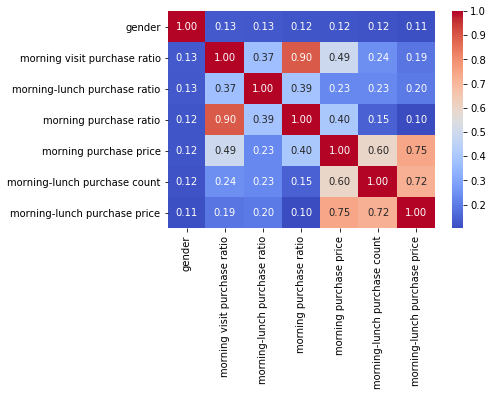

In [33]:
sns.heatmap(train[["gender","morning visit purchase ratio","morning-lunch purchase ratio",
                   "morning purchase ratio","morning purchase price","morning-lunch purchase count",
                   "morning-lunch purchase price"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

In [34]:
# lightgbm 알고리즘에 한글로된 컬럼은 넣어지지 않아 이를 해결하고
# 학습시키기위해 한글로 된 컬럼명을 영어로 바꿔줍니다.
def data_setting(data):
    data['purchasing number'] = data['구매건수']
    data['average purchase price'] = data['평균구매가격']
    data['visit days'] = data['내점일수']
    data['spring purchase number'] = data['봄_구매건수']
    data['summer purchase number'] = data['여름_구매건수']
    data['autumn purchase number'] = data['가을_구매건수']
    data['winter purchase number'] = data['겨울_구매건수']
    data['morning purchase number'] = data['아침_구매건수']
    data['lunch purchase number'] = data['점심_구매건수']
    return

In [35]:
data_setting(train)
train.head(1).T

custid,18
gender,0.0
총구매액,680100.0
구매건수,15.0
평균구매가격,45340.0
평균할부개월수,1.7
구매브랜드종류,9.0
내점일수,10.0
morning visit purchase ratio,0.0
수입상품_구매비율,26.7
주말방문비율,100.0


In [36]:
# 학습용 데이터 확정
trainCP = train.copy()
trainLD = trainCP.drop(['총구매액','구매브랜드종류','주말방문비율','저녁_구매건수',
                          '평균할부개월수','수입상품_구매비율','주구매코너'], axis=1)
trainFD = trainLD.drop(['구매건수','평균구매가격','내점일수','봄_구매건수','여름_구매건수',
                          '가을_구매건수','겨울_구매건수','아침_구매건수','점심_구매건수'], axis=1)
dy = trainFD['gender']
dx = trainFD.drop(['gender'], axis=1)

In [37]:
print(dx.shape)
trainFD.head(1)

(5000, 15)


,gender,morning visit purchase ratio,morning purchase price,morning purchase ratio,morning-lunch purchase price,morning-lunch purchase count,morning-lunch purchase ratio,purchasing number,average purchase price,visit days,spring purchase number,summer purchase number,autumn purchase number,winter purchase number,morning purchase number,lunch purchase number
custid,,,,,,,,,,,,,,,,
18,0,0.0,0.0,0.0,408060.0,9.0,0.6,15,45340,10,6.0,0.0,0.0,9.0,0.0,9.0


- <font color = "#CC3D3D">최종적으로 SMOTE + Tomek의 복합샘플링기법을 이용한 X_resampled,y_resampled를 사용함<font>

In [38]:
X_resampled, y_resampled = SMOTETomek(random_state=0).fit_sample(dx, dy)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=0)
print(dx.shape, X_resampled.shape, X_train.shape, X_test.shape)

(5000, 15) (5914, 15) (4435, 15) (1479, 15)


- <font color = "#CC3D3D">ML_exam_v1.0 파일에 있는 코드를 이용해 최고 0.784의 예측률을 만들어냄<font>

In [39]:
def bestGBDTNextModel(model, isKfold, nfold, searchCV, Xtrain, ytrain, Xtest, ytest, nIter, scoring, errScore, verbose, nJobs):
    grd_prams = {}
    classifier = LGBMClassifier(random_state=0, objective='binary:logistic')
    cv = KFold(n_splits=nfold, shuffle=True, random_state=0)
    if model == 'LGBM':  
        grd_prams.update({'max_depth': [50, 100],
              'learning_rate' : [0.01, 0.05],
              'num_leaves': [150, 200],
              'n_estimators': [300, 400],
              'num_boost_round':[4000, 5000],
              'subsample': [0.5, 1],
              'reg_alpha': [0.01, 0.1],
              'reg_lambda': [0.01, 0.1],
              'min_data_in_leaf': [20, 30],
              'lambda_l1': [0.01, 0.1],
              'lambda_l2': [0.01, 0.1]
            })
        classifier = LGBMClassifier(random_state=0, boosting_type='gbdt', objective='binary', metric='auc')
    if isKfold == False:
        cv = StratifiedShuffleSplit(n_splits=nfold, test_size=0.2, random_state=0)
    grid_ = RandomizedSearchCV(classifier, param_distributions=grd_prams,
                               n_iter=nIter, scoring=scoring, error_score=errScore, verbose=verbose, n_jobs=nJobs, cv=cv)
    grid_.fit(Xtrain, ytrain)
    score_ = grid_.score(Xtest, ytest)
    print("{} grid_.best_score {}".format(model, np.round(grid_.best_score_,3)))
    print("{} grid_.best_score {}".format(model, np.round(score_,3)))
    print("{} best_estimator {}".format(model, grid_.best_estimator_))
    return grid_.best_params_

In [41]:
best_param = bestGBDTNextModel('LGBM', False, 5, 'RANDOM', X_train, y_train, X_test, y_test, 15, 'roc_auc', 0, 3, -1)
lgbm = LGBMClassifier(**best_param)
score_lgbm = lgbm.fit(X_train, y_train).score(X_test, y_test)
print("score_lgbm ::: {}".format(score_lgbm))
print("-----------------------------------")
y_lgbm = lgbm.predict(X_test)
print(classification_report(y_test, y_lgbm))

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  6.5min finished


LGBM grid_.best_score 0.823
LGBM grid_.best_score 0.86
LGBM best_estimator LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', lambda_l1=0.01, lambda_l2=0.01,
               learning_rate=0.01, max_depth=50, metric='auc',
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=20, min_split_gain=0.0, n_estimators=400,
               n_jobs=-1, num_boost_round=4000, num_leaves=150,
               objective='binary', random_state=0, reg_alpha=0.1,
               reg_lambda=0.1, silent=True, subsample=0.5,
               subsample_for_bin=200000, subsample_freq=0)
score_lgbm ::: 0.7843137254901961
-----------------------------------
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       738
           1       0.80      0.76      0.78       741

    accuracy                           0.78      1479
   macro avg       0.79      0.78      0.

# Deployment

In [40]:
# 1. 예측용 데이터(test.csv) 불러오기
test = pd.read_csv('data/test.csv', encoding='cp949', index_col='custid')
test_ = test.copy()
test_.head(1)

,총구매액,구매건수,평균구매가격,평균할부개월수,구매브랜드종류,내점일수,수입상품_구매비율,주말방문비율,가을_구매건수,겨울_구매건수,봄_구매건수,여름_구매건수,아침_구매건수,저녁_구매건수,점심_구매건수,주구매코너
custid,,,,,,,,,,,,,,,,
100001,3439000,25,137560,2.2,19,16,12.0,31.2,5.0,4.0,7.0,9.0,13.0,1.0,11.0,장.신구


In [41]:
# 예측용 데이터의 결측치 확인
test_.isnull().sum()

총구매액            0
구매건수            0
평균구매가격          0
평균할부개월수         0
구매브랜드종류         0
내점일수            0
수입상품_구매비율       0
주말방문비율          0
가을_구매건수       948
겨울_구매건수       911
봄_구매건수        681
여름_구매건수       991
아침_구매건수      1392
저녁_구매건수      1025
점심_구매건수       139
주구매코너           0
dtype: int64

In [42]:
# 2. test 파일도 동일하게 결측치 처리
test_.fillna(0, inplace=True)

# 3. train 파일과 동일하게 범주형을 숫자형으로 바꿔줍니다.
obj = ['주구매코너']
test_[obj] = test[obj].apply(lambda x: x.astype('category').cat.codes)

# 4. test 파일에 train과 동일한 파생변수 추가
create_feature(test_)

# 5. 한글컬럼명을 영어로 바꿔줌
data_setting(test_)

# 6. 예측용 데이터로 변형
testCP = test_.copy()
testLD = testCP.drop(['총구매액','구매브랜드종류','주말방문비율','저녁_구매건수',
                          '평균할부개월수','수입상품_구매비율','주구매코너'], axis=1)
pred_test = testLD.drop(['구매건수','평균구매가격','내점일수','봄_구매건수','여름_구매건수',
                          '가을_구매건수','겨울_구매건수','아침_구매건수','점심_구매건수'], axis=1)

# 예측용 데이터안에 결측값이 채워졌는지 확인 합니다.
display(pred_test.isnull().sum().sum())
# 예측용 데이터가 train 학습용 데이터와 일치하는지 확인
display(dx.shape, pred_test.shape)

pred_test.head(1)

0

(5000, 15)

(5000, 15)

,morning visit purchase ratio,morning purchase price,morning purchase ratio,morning-lunch purchase price,morning-lunch purchase count,morning-lunch purchase ratio,purchasing number,average purchase price,visit days,spring purchase number,summer purchase number,autumn purchase number,winter purchase number,morning purchase number,lunch purchase number
custid,,,,,,,,,,,,,,,
100001,0.8125,1788280.0,0.0,3301440.0,24.0,0.96,25,137560,16,7.0,9.0,5.0,4.0,13.0,11.0


### Best Model

In [45]:
# 앞에서 학습한 베스트 모델 예측률 : 0.79
# 학습데이터에 알맞은 best estimators
super_model = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', lambda_l1=0.1, lambda_l2=0.01,
               learning_rate=0.01, max_depth=100, metric='auc',
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=20, min_split_gain=0.0, n_estimators=300,
               n_jobs=-1, num_boost_round=5000, num_leaves=200,
               objective='binary', random_state=0, reg_alpha=0.01,
               reg_lambda=0.01, silent=True, subsample=0.5,
               subsample_for_bin=200000, subsample_freq=0)
best_score = super_model.fit(X_train, y_train).score(X_test, y_test)
y_super = super_model.predict(X_test)

print("super_model ---------------------------------------{}".format(np.round(best_score,3)))
print(classification_report(y_test, y_super))

super_model ---------------------------------------0.786
              precision    recall  f1-score   support

           0       0.77      0.82      0.79       738
           1       0.81      0.75      0.78       741

    accuracy                           0.79      1479
   macro avg       0.79      0.79      0.79      1479
weighted avg       0.79      0.79      0.79      1479



- <font color = "#CC3D3D">best model 성능확인<font>

#### AUC

In [46]:
fpr, tpr, _ = roc_curve(y_test, super_model.predict_proba(X_test)[:,1])
auc(fpr, tpr)

0.8578643816127769

##### Define ROC curve drawing fuction ####

In [47]:
def plot_roc_curve(fpr, tpr, model, color=None) :
    model = model + ' (auc = %0.3f)' % auc(fpr, tpr)
    plt.plot(fpr, tpr, label=model, color=color)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.axis([0,1,0,1])
    plt.xlabel('FPR (1 - specificity)')
    plt.ylabel('TPR (recall)')
    plt.title('ROC curve')
    plt.legend(loc="lower right")

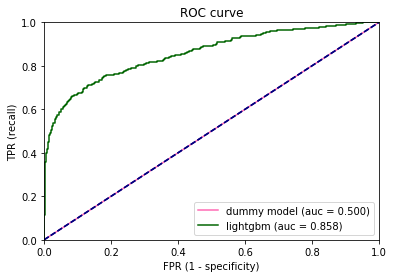

In [48]:
fpr_dummy, tpr_dummy, _ = roc_curve(y_test, 
                                    dummy.predict_proba(X_test)[:,1])
plot_roc_curve(fpr_dummy, tpr_dummy, 'dummy model', 'hotpink')
fpr_tree, tpr_tree, _ = roc_curve(y_test, 
                                  super_model.predict_proba(X_test)[:,1])
plot_roc_curve(fpr_tree, tpr_tree, 'lightgbm', 'darkgreen')

- <font color = "#CC3D3D">아래 그림상의 0.85와 0.95사이의 모형성능을 보임<font>

<font color='green'>
<p>
### ROC & AUC 

<img align="left" src="http://drive.google.com/uc?export=view&id=1Htx445FclSqHhhNxPT_uOYQOBiuneWXJ" width=auto height=auto>

#### PR curve

In [49]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(precisions, recalls) :
    plt.plot(recalls, precisions, color='blue')
    plt.axis([0,1,0,1])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR curve')

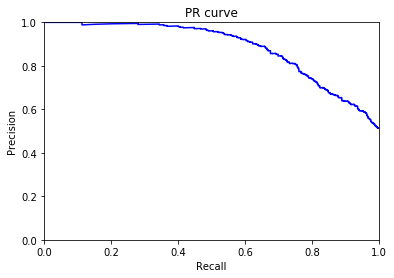

In [50]:
precisions, recalls, _ = precision_recall_curve(y_test, 
                                    super_model.predict_proba(X_test)[:,1])
plot_precision_recall_curve(precisions, recalls)

### predict

In [51]:
# 선정한 best model을 이용해 성별 예측
new_data = pred_test.copy()
new_data['gender_predict'] = super_model.predict(pred_test)
new_data['gender_pred_prob'] = super_model.predict_proba(pred_test)[:,1]

In [52]:
test.tail()

,총구매액,구매건수,평균구매가격,평균할부개월수,구매브랜드종류,내점일수,수입상품_구매비율,주말방문비율,가을_구매건수,겨울_구매건수,봄_구매건수,여름_구매건수,아침_구매건수,저녁_구매건수,점심_구매건수,주구매코너
custid,,,,,,,,,,,,,,,,
104996,670690,5,134138,1.4,5,4,0.0,75.0,1.0,2.0,2.0,NaN,1.0,1.0,3.0,일.반식품
104997,628700,13,48362,1.8,10,7,7.7,42.9,NaN,5.0,1.0,7.0,NaN,3.0,10.0,조.리욕실
104998,960923,12,80077,1.8,7,7,0.0,42.9,4.0,1.0,6.0,1.0,NaN,NaN,12.0,일.반식품
104999,786600,14,56186,1.7,12,9,14.3,55.6,NaN,7.0,4.0,3.0,2.0,4.0,8.0,화.장품
105000,2568073,76,33790,1.6,23,35,10.5,22.9,23.0,20.0,9.0,24.0,11.0,4.0,61.0,일.반식품


In [53]:
new_data.tail()

,morning visit purchase ratio,morning purchase price,morning purchase ratio,morning-lunch purchase price,morning-lunch purchase count,morning-lunch purchase ratio,purchasing number,average purchase price,visit days,spring purchase number,summer purchase number,autumn purchase number,winter purchase number,morning purchase number,lunch purchase number,gender_predict,gender_pred_prob
custid,,,,,,,,,,,,,,,,,
104996,0.250000,134138.0,0.200000,536552.0,4.0,0.800000,5,134138,4,2.0,0.0,1.0,2.0,1.0,3.0,0,0.001291
104997,0.000000,0.0,0.000000,483620.0,10.0,0.769231,13,48362,7,1.0,7.0,0.0,5.0,0.0,10.0,0,0.157573
104998,0.000000,0.0,0.000000,960924.0,12.0,1.000000,12,80077,7,6.0,1.0,4.0,1.0,0.0,12.0,0,0.047800
104999,0.222222,112372.0,0.000000,561860.0,10.0,0.714286,14,56186,9,4.0,3.0,0.0,7.0,2.0,8.0,0,0.027451
105000,0.314286,371690.0,0.144737,2432880.0,72.0,0.947368,76,33790,35,9.0,24.0,23.0,20.0,11.0,61.0,0,0.433519


In [54]:
predicted = new_data[['gender_predict', 'gender_pred_prob']]

target = pd.merge(test, predicted, on='custid')
target.tail()

,총구매액,구매건수,평균구매가격,평균할부개월수,구매브랜드종류,내점일수,수입상품_구매비율,주말방문비율,가을_구매건수,겨울_구매건수,봄_구매건수,여름_구매건수,아침_구매건수,저녁_구매건수,점심_구매건수,주구매코너,gender_predict,gender_pred_prob
custid,,,,,,,,,,,,,,,,,,
104996,670690,5,134138,1.4,5,4,0.0,75.0,1.0,2.0,2.0,NaN,1.0,1.0,3.0,일.반식품,0,0.001291
104997,628700,13,48362,1.8,10,7,7.7,42.9,NaN,5.0,1.0,7.0,NaN,3.0,10.0,조.리욕실,0,0.157573
104998,960923,12,80077,1.8,7,7,0.0,42.9,4.0,1.0,6.0,1.0,NaN,NaN,12.0,일.반식품,0,0.047800
104999,786600,14,56186,1.7,12,9,14.3,55.6,NaN,7.0,4.0,3.0,2.0,4.0,8.0,화.장품,0,0.027451
105000,2568073,76,33790,1.6,23,35,10.5,22.9,23.0,20.0,9.0,24.0,11.0,4.0,61.0,일.반식품,0,0.433519


In [55]:
# 예측한 test data를 csv파일로 저장하여 제출
target.to_csv("gender.csv", encoding='utf-8')
pd.read_csv("gender.csv").count()

custid              5000
총구매액                5000
구매건수                5000
평균구매가격              5000
평균할부개월수             5000
구매브랜드종류             5000
내점일수                5000
수입상품_구매비율           5000
주말방문비율              5000
가을_구매건수             4052
겨울_구매건수             4089
봄_구매건수              4319
여름_구매건수             4009
아침_구매건수             3608
저녁_구매건수             3975
점심_구매건수             4861
주구매코너               5000
gender_predict      5000
gender_pred_prob    5000
dtype: int64

In [56]:
predicted_data = pd.read_csv('gender.csv')
predicted_data

,custid,총구매액,구매건수,평균구매가격,평균할부개월수,구매브랜드종류,내점일수,수입상품_구매비율,주말방문비율,가을_구매건수,겨울_구매건수,봄_구매건수,여름_구매건수,아침_구매건수,저녁_구매건수,점심_구매건수,주구매코너,gender_predict,gender_pred_prob
0,100001,3439000,25,137560,2.2,19,16,12.0,31.2,5.0,4.0,7.0,9.0,13.0,1.0,11.0,장.신구,0,0.268422
1,100002,2073090,39,53156,1.3,18,29,0.0,20.7,13.0,8.0,10.0,8.0,4.0,10.0,25.0,유.아동복,1,0.534733
2,100003,1303800,22,59264,1.8,14,12,0.0,41.7,6.0,7.0,3.0,6.0,3.0,1.0,18.0,유.아동복,1,0.560825
3,100004,6696522,46,145577,1.7,31,22,37.0,50.0,5.0,15.0,9.0,17.0,NaN,4.0,42.0,수.입명품,0,0.012044
4,100005,1297640,26,49909,2.3,13,9,11.5,22.2,18.0,NaN,5.0,3.0,NaN,NaN,26.0,스.포츠,0,0.075072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,104996,670690,5,134138,1.4,5,4,0.0,75.0,1.0,2.0,2.0,NaN,1.0,1.0,3.0,일.반식품,0,0.001291
4996,104997,628700,13,48362,1.8,10,7,7.7,42.9,NaN,5.0,1.0,7.0,NaN,3.0,10.0,조.리욕실,0,0.157573
4997,104998,960923,12,80077,1.8,7,7,0.0,42.9,4.0,1.0,6.0,1.0,NaN,NaN,12.0,일.반식품,0,0.047800
4998,104999,786600,14,56186,1.7,12,9,14.3,55.6,NaN,7.0,4.0,3.0,2.0,4.0,8.0,화.장품,0,0.027451


In [57]:
# 예측된 데이터상에 여성이 남성의 3.2444821731748728 배이다.
predicted_data['gender_predict'].value_counts()

0    3822
1    1178
Name: gender_predict, dtype: int64

In [56]:
3822/1178

3.2444821731748728